In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./archive/fraud test.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [34]:
df.dtypes

Unnamed: 0                        int64
trans_date_trans_time            object
cc_num                          float64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
age                               int64
dtype: object

In [33]:
# Create an age column
df['dob'] = pd.to_datetime(df["dob"])

today = pd.Timestamp.today()
def cal_age(dt):
    age = today.year - dt.year
    if dt.month < today.month:
        age -= 1
    
    return int(age)
        
df['age'] = df['dob'].apply(cal_age)
df['age'].head()

0    55
1    33
2    54
3    37
4    69
Name: age, dtype: int64

In [47]:
cat_cols = ["category", "gender", "state"]
cont_cols = ["amt", "zip", "lat", "long", "city_pop", "age", "merch_lat", "merch_long"]
y_col = "is_fraud"

In [48]:
for col in cat_cols:
    df[col] = df[col].astype("category")

In [49]:
df.dtypes

Unnamed: 0                        int64
trans_date_trans_time            object
cc_num                          float64
merchant                         object
category                       category
amt                             float64
first                            object
last                             object
gender                         category
street                           object
city                             object
state                          category
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
age                               int64
dtype: object

In [50]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cats[:5]

array([[10,  1, 39],
       [10,  0, 43],
       [ 5,  0, 33],
       [ 9,  1,  8],
       [13,  1, 21]], dtype=int8)

In [56]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts[:5]

array([[ 2.86000000e+00,  2.92090000e+04,  3.39659000e+01,
        -8.09355000e+01,  3.33497000e+05,  5.50000000e+01,
         3.39863910e+01, -8.12007140e+01],
       [ 2.98400000e+01,  8.40020000e+04,  4.03207000e+01,
        -1.10436000e+02,  3.02000000e+02,  3.30000000e+01,
         3.94504980e+01, -1.09960431e+02],
       [ 4.12800000e+01,  1.17100000e+04,  4.06729000e+01,
        -7.35365000e+01,  3.44960000e+04,  5.40000000e+01,
         4.04958100e+01, -7.41961110e+01],
       [ 6.00500000e+01,  3.27800000e+04,  2.85697000e+01,
        -8.08191000e+01,  5.47670000e+04,  3.70000000e+01,
         2.88123980e+01, -8.08830610e+01],
       [ 3.19000000e+00,  4.96320000e+04,  4.42529000e+01,
        -8.50170000e+01,  1.12600000e+03,  6.90000000e+01,
         4.49591480e+01, -8.58847340e+01]])

In [57]:
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

C:\Users\Abhijith.Sunder\AppData\Local\Temp\ipykernel_2508\849400687.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cats = torch.tensor(cats, dtype=torch.int64)


tensor([[10,  1, 39],
        [10,  0, 43],
        [ 5,  0, 33],
        [ 9,  1,  8],
        [13,  1, 21]])

In [58]:
conts = torch.tensor(conts, dtype=torch.float32)
conts[:5]

tensor([[ 2.8600e+00,  2.9209e+04,  3.3966e+01, -8.0936e+01,  3.3350e+05,
          5.5000e+01,  3.3986e+01, -8.1201e+01],
        [ 2.9840e+01,  8.4002e+04,  4.0321e+01, -1.1044e+02,  3.0200e+02,
          3.3000e+01,  3.9450e+01, -1.0996e+02],
        [ 4.1280e+01,  1.1710e+04,  4.0673e+01, -7.3536e+01,  3.4496e+04,
          5.4000e+01,  4.0496e+01, -7.4196e+01],
        [ 6.0050e+01,  3.2780e+04,  2.8570e+01, -8.0819e+01,  5.4767e+04,
          3.7000e+01,  2.8812e+01, -8.0883e+01],
        [ 3.1900e+00,  4.9632e+04,  4.4253e+01, -8.5017e+01,  1.1260e+03,
          6.9000e+01,  4.4959e+01, -8.5885e+01]])

In [59]:
y = torch.tensor(df[y_col].values).flatten()
y[:5]

tensor([0, 0, 0, 0, 0])

In [66]:
cat_sz = [len(df[col].cat.categories) for col in cat_cols]
emb_sz = [(sz, min(50, (sz+1)//2)) for sz in cat_sz]
emb_sz

[(14, 7), (2, 1), (50, 25)]

In [67]:
class TabularModel(nn.Module):
    def __init__(self,emb_sz,n_cont,out_sz,layers,p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sz])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layer_list = []
        n_emb = sum([nf for ni, nf in emb_sz])
        n_in = n_emb + n_cont
        
        for i in layers:
            layer_list.append(nn.Linear(n_in,i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i
            
            
        layer_list.append(nn.Linear(layers[-1],out_sz))
        
        self.layers = nn.Sequential(*layer_list)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont], 1)
        x = self.layers(x)
        return x

In [80]:
model = TabularModel(emb_sz, conts.shape[1], 2, [200,100], p=0.4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [81]:
b = len(df)
t = int(0.1 * b)
cat_train = cats[:b-t]
cat_test = cats[b-t:b]
cont_train = conts[:b-t]
cont_test = conts[b-t:b]
y_train = y[:b-t]
y_test = y[b-t:b]

In [82]:
import time

start_time = time.time()
epochs = 300
losses = []
for i in range(epochs):
    i += 1
    y_pred = model(cat_train, cont_train)
    loss = criterion(y_pred, y_train)
    
    losses.append(loss.item())
    if i % 10 == 0:
        print(f"At Epoch:{i}\tLoss: {loss.item():8.2f}")
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("Training complete!")
print(f"Took: {(time.time()-start_time)/60} minutes")

At Epoch:10	Loss:     0.68
At Epoch:20	Loss:     0.47
At Epoch:30	Loss:     0.17
At Epoch:40	Loss:     0.05
At Epoch:50	Loss:     0.03
At Epoch:60	Loss:     0.02
At Epoch:70	Loss:     0.02
At Epoch:80	Loss:     0.02
At Epoch:90	Loss:     0.02
At Epoch:100	Loss:     0.02
At Epoch:110	Loss:     0.02
At Epoch:120	Loss:     0.02
At Epoch:130	Loss:     0.02
At Epoch:140	Loss:     0.02
At Epoch:150	Loss:     0.02
At Epoch:160	Loss:     0.02
At Epoch:170	Loss:     0.01
At Epoch:180	Loss:     0.01
At Epoch:190	Loss:     0.01
At Epoch:200	Loss:     0.01
At Epoch:210	Loss:     0.01
At Epoch:220	Loss:     0.01
At Epoch:230	Loss:     0.01
At Epoch:240	Loss:     0.01
At Epoch:250	Loss:     0.01
At Epoch:260	Loss:     0.01
At Epoch:270	Loss:     0.01
At Epoch:280	Loss:     0.01
At Epoch:290	Loss:     0.01
At Epoch:300	Loss:     0.01
Training complete!
Took: 16.817436130841575 minutes


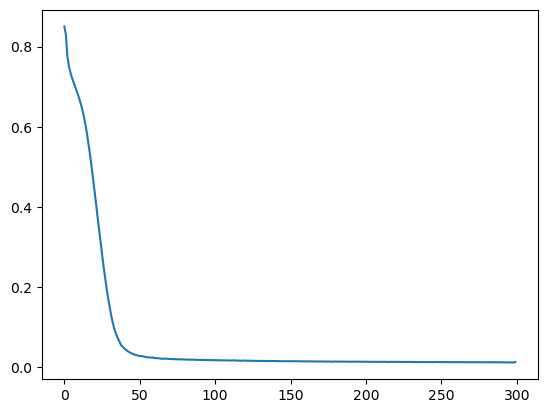

In [83]:
plt.plot(range(epochs), losses)

In [85]:
with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = criterion(y_val, y_test)

print(f"Loss on the test set: {loss.item():0.3f}")

Loss on the test set: 0.004


In [86]:
rows = len(y_test)
correct = 0
for i in range(rows):
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f"The model got {correct}/{rows}: {100*correct/rows}%")

The model got 55519/55571: 99.90642601356822%


In [91]:
torch.save(model.state_dict(), "FraudDetection.pt")